In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images, [label] * len(images)

In [4]:
data_dir = 'dataset'
folders = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
labels = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}

all_images = []
all_labels = []
for folder in folders:
    images, label_list = load_images_from_folder(os.path.join(data_dir, folder), labels[folder])
    all_images.extend(images)
    all_labels.extend(label_list)

all_images = np.array(all_images).reshape(-1, 128, 128, 1) / 255.0
all_labels = to_categorical(all_labels, num_classes=4)

data_augmentation = ImageDataGenerator(
    width_shift_range=0.05,  
    height_shift_range=0.05, 
    zoom_range=0.05,         
    horizontal_flip=True,    
    fill_mode='nearest'
)

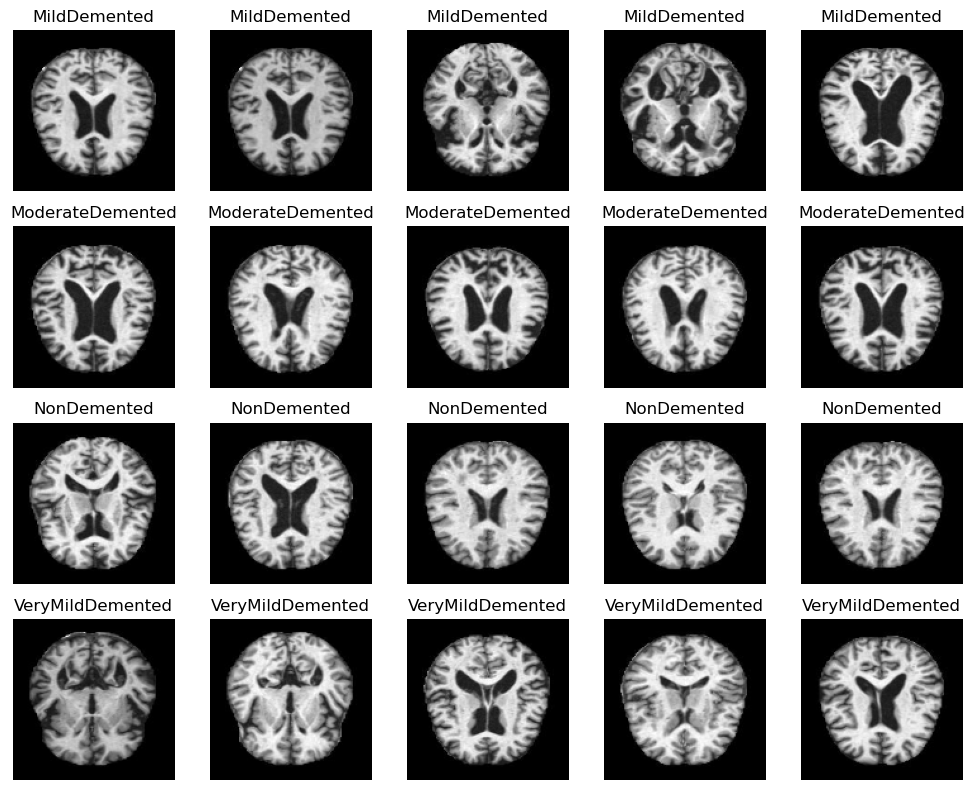

In [5]:
def display_images(images, labels, class_names, num_images=5):
    fig, axes = plt.subplots(nrows=len(class_names), ncols=num_images, figsize=(10, 2 * len(class_names)))
    for i, class_name in enumerate(class_names):
        class_images = [img for img, label in zip(images, labels) if np.argmax(label) == i]
        for j in range(num_images):
            if j < len(class_images):
                ax = axes[i, j]
                ax.imshow(class_images[j].squeeze(), cmap='gray')
                ax.set_title(class_name)
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
display_images(all_images, all_labels, class_names, num_images=5)


In [6]:
fold_results = {
    'accuracy': [],
    'loss': [],
    'confusion_matrices': [],
    'history': []
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
for train_index, val_index in kf.split(all_images, np.argmax(all_labels, axis=1)):
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]

    train_generator = data_augmentation.flow(X_train, y_train, batch_size=32)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




## In this notebook we do not go through the training phase again. Instead we just import the model from the trained CNN

In [ ]:
# Train the model
    print(f'Training for fold {fold_no}...')
    history = model.fit(
        train_generator,
        epochs=150, 
        validation_data=(X_val, y_val),
        steps_per_epoch=len(X_train) // 32
    )
    fold_results['history'].append(history)

    # Evaluate the model
    scores = model.evaluate(X_val, y_val, verbose=0)
    fold_results['accuracy'].append(scores[1])
    fold_results['loss'].append(scores[0])

    # Confusion Matrix for the current fold
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    fold_results['confusion_matrices'].append(cm)

    print(f'Confusion Matrix for fold {fold_no}:')
    print(cm)

    fold_no += 1


In [7]:
# LOAD SAVED MODEL RESULTS
from tensorflow.keras.models import load_model

model = load_model('alzheimers_CNN_aug_model.h5')

## Class Activation Maps (Grad-CAMs)

In [8]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 128)      

In [9]:
import tensorflow as tf
import matplotlib.cm as cm
import random

# Function for creating Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

200/200 [==============================] - 5s 26ms/step


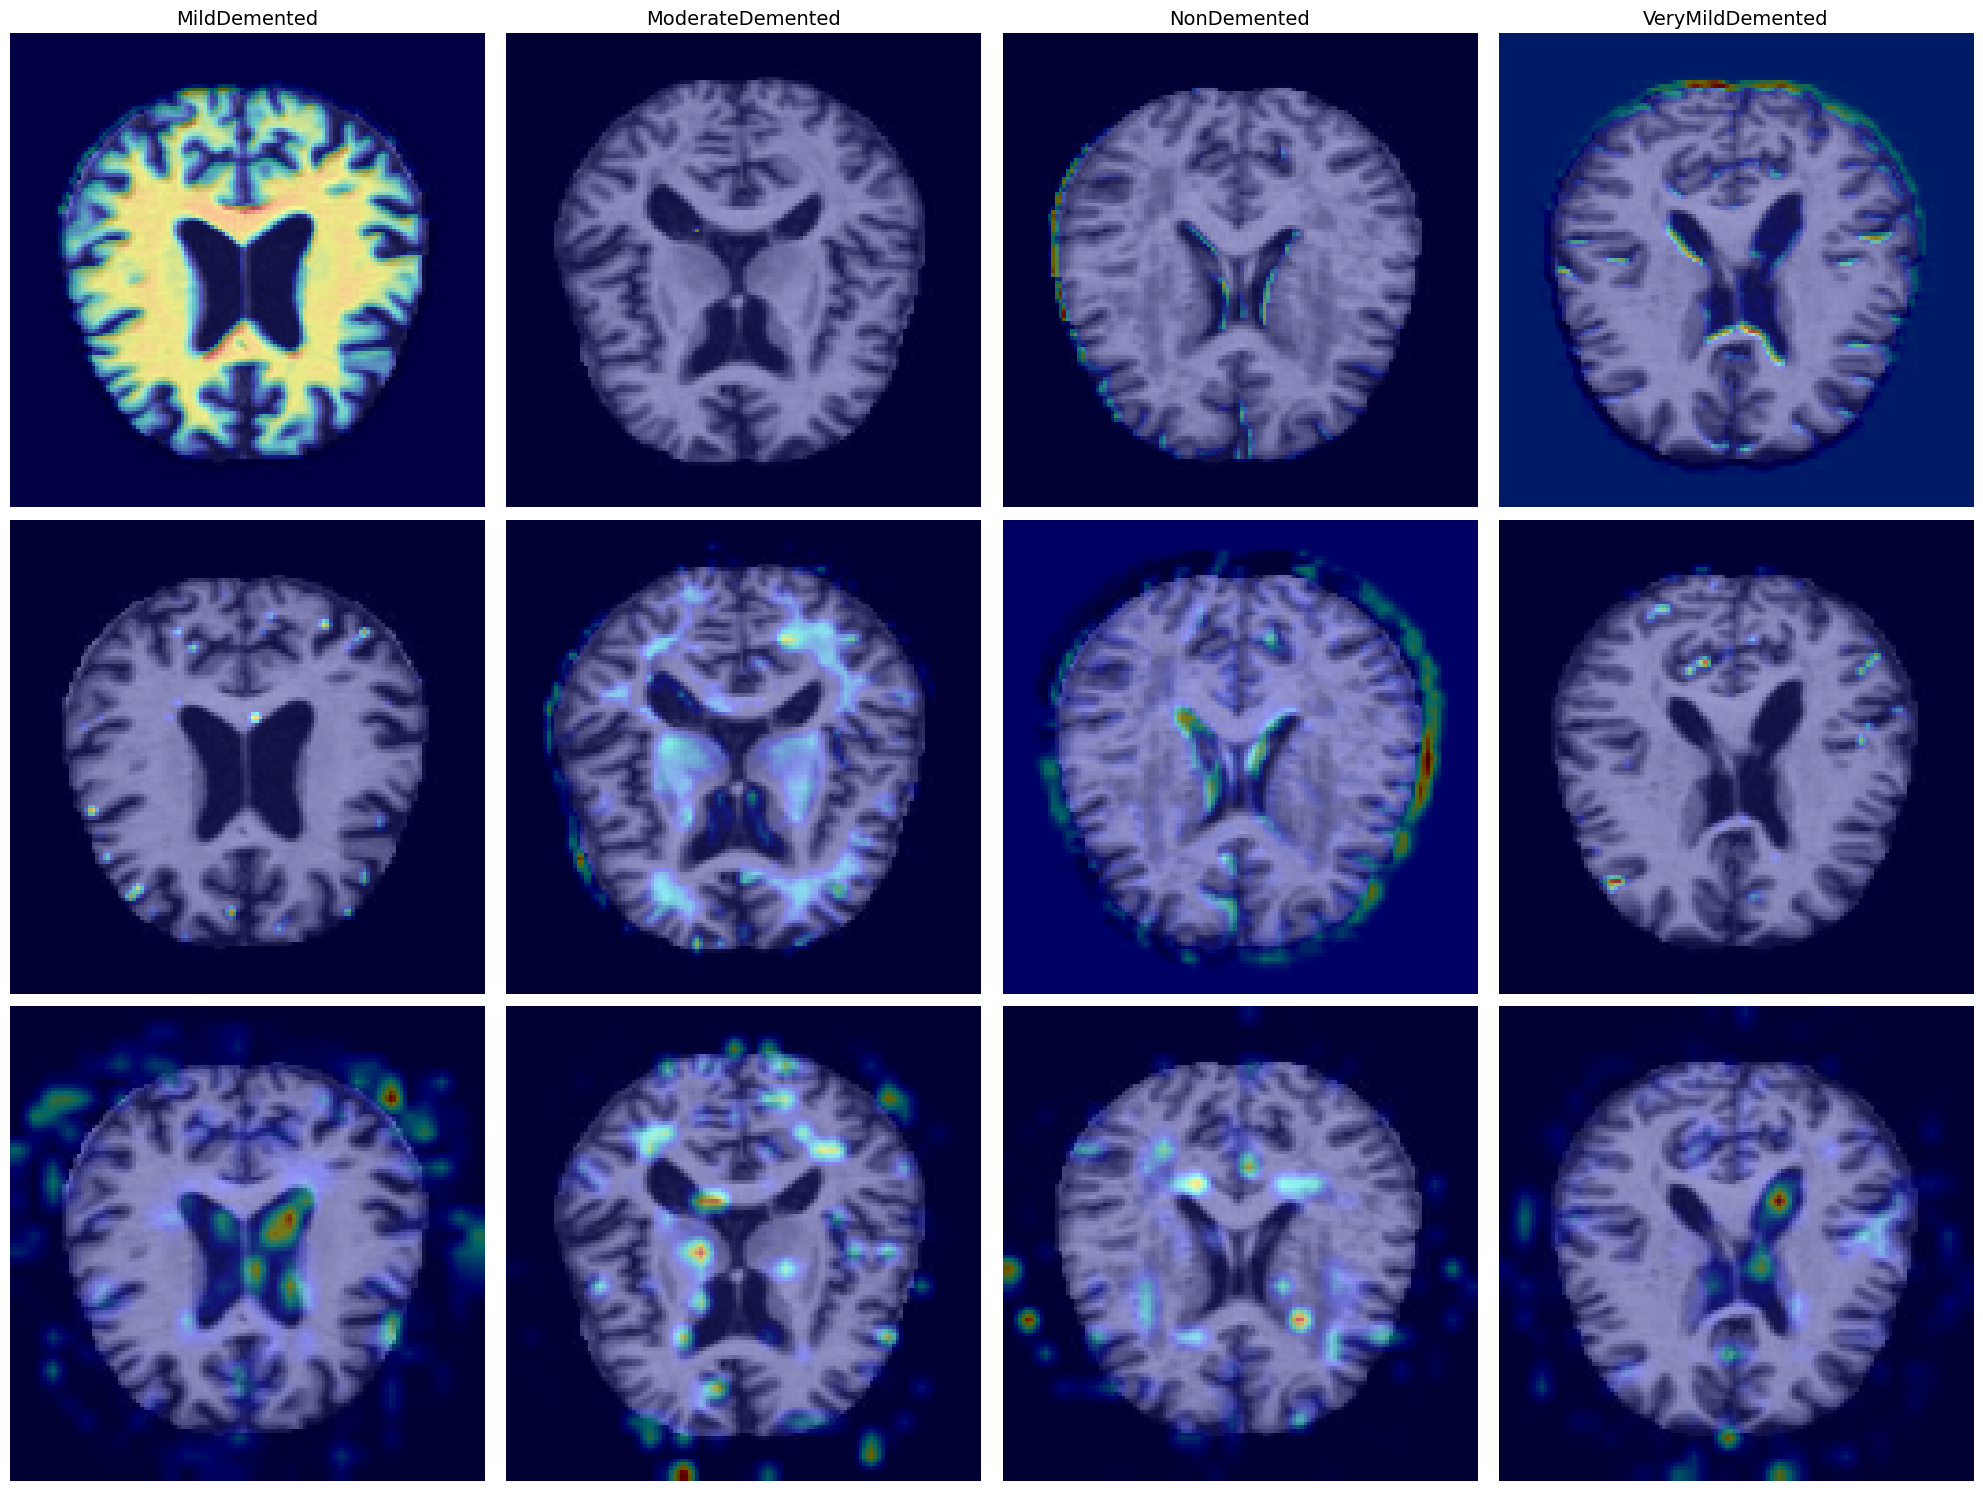

In [19]:
# Define the convolutional layers (names from model)
conv_layer_names = ["conv2d_12", "conv2d_13", "conv2d_14"]
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

predicted_classes = np.argmax(model.predict(all_images), axis=1)
true_classes = np.argmax(all_labels, axis=1)

# Use only correctly classified images
correctly_classified_indices = {}
for i, class_name in enumerate(class_names):
    class_indices = np.where(true_classes == i)[0]
    correctly_classified = class_indices[predicted_classes[class_indices] == i]
    correctly_classified_indices[class_name] = correctly_classified

# Select 1 random correctly classified image, 1 for for each class
selected_indices = {class_name: random.choice(correctly_classified_indices[class_name]) for class_name in class_names}

# PLOTTING
fig, axs = plt.subplots(len(conv_layer_names), len(class_names), figsize=(20, 15))

for row, layer_name in enumerate(conv_layer_names):
    for col, class_name in enumerate(class_names):
        img_index = selected_indices[class_name]
        img_array = all_images[img_index:img_index+1]
        heatmap = make_gradcam_heatmap(img_array, model, layer_name)

        original_img = all_images[img_index].squeeze()
        original_img = (original_img - np.min(original_img)) / (np.max(original_img) - np.min(original_img))
        original_img = np.uint8(255 * original_img)

        heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)

        # Overlaying the heatmap on top of the original image
        intensity = 0.4
        superimposed_img = cv2.addWeighted(original_img_rgb, 1 - intensity, heatmap_colored, intensity, 0)

        # Plotting
        ax = axs[row, col]
        ax.imshow(superimposed_img[..., ::-1])
        ax.axis('off')
        if col == 0:
            ax.set_ylabel(layer_name, fontsize=14)
        if row == 0:
            ax.set_title(class_name, fontsize=14)

plt.tight_layout()
